# Autoencoders

In [1]:
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np

## 1. Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))

In [4]:
x_train = np.float32(x_train)/255
x_test = np.float32(x_test)/255

## 2. Encoder

In [5]:
inp_enc = layers.Input(shape = (28,28,1))
conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inp_enc)
conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(conv1)
flat1 = layers.Flatten()(conv2)
dens1 = layers.Dense(units=20, name='latent_vector')(flat1)

In [6]:
encoder = models.Model(inputs=inp_enc, outputs=dens1, name='Encoder')

In [7]:
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 20)                62740     
                                                                 
Total params: 81,556
Trainable params: 81,556
Non-trainable params: 0
_________________________________________________________________


## 3. Decoder

In [8]:
inp_dec = layers.Input(shape=(20,))
dens2 = layers.Dense(units=3136)(inp_dec)
resh1 = layers.Reshape(target_shape=(7,7,64))(dens2)
conv3 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(resh1)
conv4 = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(conv3)

In [9]:
decoder = models.Model(inputs=inp_dec, outputs=conv4, name='Decoder')

In [10]:
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 3136)              65856     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       18464     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                                 
Total params: 84,609
Trainable params: 84,609
Non-trainable

## 4. Autoencoder

In [11]:
autoencoder = models.Model(inputs=inp_enc,outputs=decoder(encoder(inp_enc)), name='Autoencoder')

In [12]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 20)                81556     
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         84609     
                                                                 
Total params: 166,165
Trainable params: 166,165
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compilacion
autoencoder.compile(optimizer='adam', loss='mse')

In [15]:
# Entrenamiento
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test),
                epochs=25, batch_size=128)

Epoch 1/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 2/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 3/25
469/469 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 4/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 5/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 6/25
469/469 [==============================] - 3s 5ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 7/25
469/469 [==============================] - 3s 5ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 8/25
469/469 [==============================] - 3s 5ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 9/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 10/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0066 - val_loss: 0.0067

## 5. Validacion de resultados

In [17]:
test = x_test[:8,:,:,:]
test.shape

(8, 28, 28, 1)

In [18]:
predict = autoencoder.predict(test)

In [19]:
# Concatenamos las imagenes
imgs = np.concatenate([test, predict])
imgs.shape

(16, 28, 28, 1)

In [20]:
imgs = imgs.reshape((4,4,28,28))

In [23]:
# Stack vertical y horizontal
imgs = np.vstack([np.hstack(k) for k in imgs])

In [24]:
imgs.shape

(112, 112)

In [21]:
import matplotlib.pyplot as plt

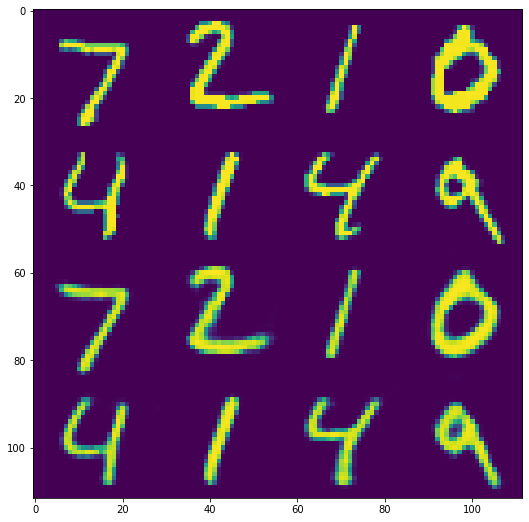

In [26]:
plt.figure(figsize=(9,9))
plt.imshow(imgs)

## 6. Denoising AutoEncoders (DAE)

In [27]:
noise1 = np.random.normal(0.25, 0.4, size = x_train.shape)
noise2 = np.random.normal(0.25, 0.4, size = x_test.shape)

In [28]:
x_train_n = x_train + noise1
x_test_n  = x_test + noise2

In [29]:
# Limitar
x_train_n = np.clip(x_train_n, 0., 1.)
x_test_n = np.clip(x_test_n, 0., 1.)

In [30]:
# Entrenar el modelo
# Entrenamiento
autoencoder.fit(x_train_n, x_train, validation_data=(x_test_n, x_test),
                epochs=40, batch_size=128)

Epoch 1/40
469/469 [==============================] - 3s 6ms/step - loss: 0.0165 - val_loss: 0.0127
Epoch 2/40
469/469 [==============================] - 3s 5ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 3/40
469/469 [==============================] - 3s 5ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 4/40
469/469 [==============================] - 3s 6ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 5/40
469/469 [==============================] - 3s 6ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 6/40
469/469 [==============================] - 3s 6ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 7/40
469/469 [==============================] - 3s 6ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 8/40
469/469 [==============================] - 3s 5ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 9/40
469/469 [==============================] - 3s 6ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 10/40
469/469 [==============================] - 3s 6ms/step - loss: 0.0108 - val_loss: 0.0112

In [31]:
# Validamos
test = x_test_n[:8,:,:,:]
predict = autoencoder.predict(test)
# Concatenamos las imagenes
imgs = np.concatenate([test, predict])
imgs = imgs.reshape((4,4,28,28))
# Stack vertical y horizontal
imgs = np.vstack([np.hstack(k) for k in imgs])

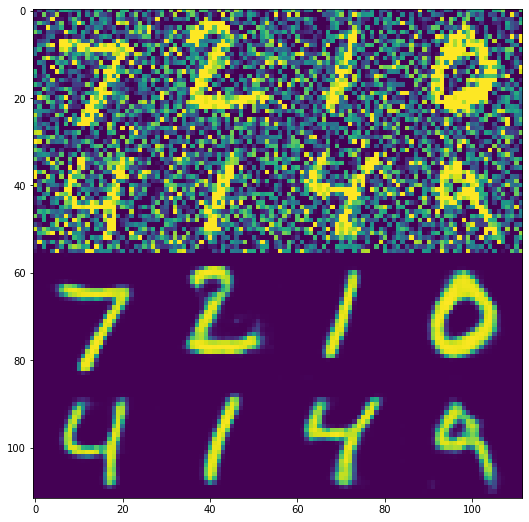

In [32]:
plt.figure(figsize=(9,9))
plt.imshow(imgs)

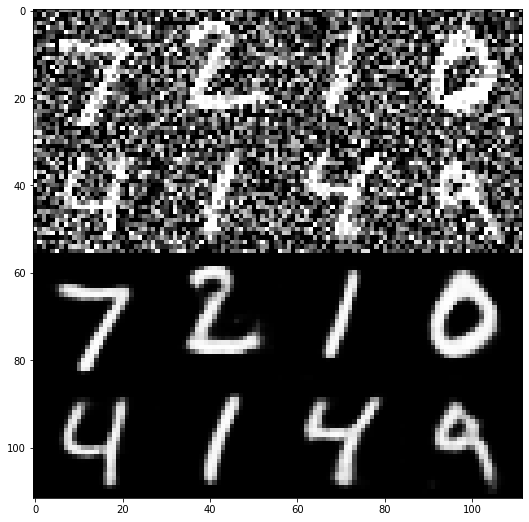

In [33]:
plt.figure(figsize=(9,9))
plt.imshow(imgs, cmap='gray')